# GoingDeeper NLP 프로젝트: 멋진 단어사전 만들기

- [ ] SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?	
        - 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?
- [ ] SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?	
        - SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
- [ ] SentencePiece의 성능을 다각도로 비교분석하였는가?	
        - SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


### 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해보기

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기  
- 학습된 모델로 sp_tokenize() 메소드 구현하기  
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기  
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기  
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기  

In [2]:
import sentencepiece as spm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from konlpy.tag import Mecab
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

### 1.데이터 확인

In [3]:
def eda(file_path):
    """
    데이터 파일을 로드하고 결측값을 제거한 후 기본적인 EDA 수행합니다.
    """
    df = pd.read_csv(file_path, sep="\t").dropna()
    print("데이터 개수:", len(df))
    print("라벨 분포:")
    print(df['label'].value_counts())
    df['length'] = df['document'].apply(lambda x: len(str(x)))
    print("문장 길이 통계:")
    print(df['length'].describe(),'\n')
    return df

In [4]:
df_train = eda("./data/ratings_train.txt")
df_test = eda("./data/ratings_test.txt")

데이터 개수: 149995
라벨 분포:
0    75170
1    74825
Name: label, dtype: int64
문장 길이 통계:
count    149995.000000
mean         35.204527
std          29.531890
min           1.000000
25%          16.000000
50%          27.000000
75%          42.000000
max         146.000000
Name: length, dtype: float64 

데이터 개수: 49997
라벨 분포:
1    25171
0    24826
Name: label, dtype: int64
문장 길이 통계:
count    49997.000000
mean        35.320259
std         29.648310
min          1.000000
25%         16.000000
50%         27.000000
75%         43.000000
max        144.000000
Name: length, dtype: float64 



In [5]:
# 데이터 전처리
def preprocess_text(df):
    df['document'] = df['document'].astype(str).str.strip()
    df['document'] = df['document'].str.replace("[^가-힣0-9a-zA-Z\s]", "", regex=True)
    return df

df_train = preprocess_text(df_train)
df_test = preprocess_text(df_test)

In [6]:
df_train = df_train.drop_duplicates(subset=['document']).reset_index(drop=True)
df_test = df_test.drop_duplicates(subset=['document']).reset_index(drop=True)

In [7]:
print(len(df_train))
df_train.head()

143899


,id,document,label,length
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,19
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,33
2,10265843,너무재밓었다그래서보는것을추천한다,0,17
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0,29
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1,61


In [8]:
print(len(df_test))
df_test.head()

48552


,id,document,label,length
0,6270596,굳,1,3
1,9274899,GDNTOPCLASSINTHECLUB,0,20
2,8544678,뭐야 이 평점들은 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0,38
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0,32
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데 왜 3D로 나와서 제 심기를 불편하게 하죠,0,49


In [9]:
# SentencePiece 모델 학습을 위한 데이터 준비
def prepare_sentencepiece_data(df, output_file):
    with open(output_file, 'w', encoding='utf-8') as f:
        for text in df['document']:
            if isinstance(text, str) and text.strip():  # 빈 문자열 제외
                f.write(text + '\n')
prepare_sentencepiece_data(df_train, 'naver_corpus.txt')

In [10]:
with open('naver_corpus.txt', 'r', encoding='utf-8') as f:
    corpus_lines = f.readlines()
print(f"Sentence count in corpus (after file write): {len(corpus_lines)}")

Sentence count in corpus (after file write): 143894


In [11]:
# SentencePiece 모델 학습
VOCAB_SIZE = 5000
MODEL_TYPE = 'bpe'  # unigram, bpe, word, char 중 선택 가능
spm.SentencePieceTrainer.Train(f'--input=naver_corpus.txt --model_prefix=sp_model --vocab_size={VOCAB_SIZE} --model_type={MODEL_TYPE} --minloglevel=0')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=naver_corpus.txt --model_prefix=sp_model --vocab_size=5000 --model_type=bpe --minloglevel=0
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: naver_corpus.txt
  input_format: 
  model_prefix: sp_model
  model_type: BPE
  vocab_size: 5000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s

In [12]:
# SentencePiece 모델 로드
sp = spm.SentencePieceProcessor()
sp.load('sp_model.model')

e=▁돌아
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=486 min_freq=34
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=476 size=1020 all=220977 active=12942 piece=▁충격
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=465 size=1040 all=222983 active=14948 piece=▁낫
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=453 size=1060 all=224050 active=16015 piece=▁따라
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=440 size=1080 all=225210 active=17175 piece=▁괴
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=431 size=1100 all=226444 active=18409 piece=수있
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=431 min_freq=32
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=422 size=1120 all=227759 active=12545 piece=▁너
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=414 size=1140 all=229279 active=14065 piece=▁훨씬
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=404 size=1160 all=230953 active=15739 piece=▁갈수록
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=395 size=

True

=294400 active=16721 piece=▁카메라
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=177 size=2360 all=295283 active=17604 piece=▁드는
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=175 size=2380 all=296014 active=18335 piece=하세요
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=173 size=2400 all=296830 active=19151 piece=▁특별
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=173 min_freq=21
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=172 size=2420 all=297679 active=15668 piece=▁독특한
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=171 size=2440 all=298394 active=16383 piece=▁유쾌한
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=169 size=2460 all=299075 active=17064 piece=▁기대를
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=167 size=2480 all=299874 active=17863 piece=▁악역
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=165 size=2500 all=300766 active=18755 piece=▁깔끔
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=165 min_freq=21
bpe_model_trainer.cc(258)

In [13]:
# SentencePiece를 활용한 인코딩 및 디코딩 예제
sample_sentence = "아버지가방에들어가신다."
token_ids = sp.encode_as_ids(sample_sentence)
print("Tokenized IDs:", token_ids)
print("Decoded Sentence:", sp.decode_ids(token_ids))

Tokenized IDs: [6, 3597, 834, 3673, 3435, 1329, 3431, 3525, 3425, 0]
Decoded Sentence: 아버지가방에들어가신다 ⁇ 


=▁f
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=117 size=3360 all=332244 active=18521 piece=ov
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=117 size=3380 all=332868 active=19145 piece=봤습니다
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=116 size=3400 all=333436 active=19713 piece=▁최강
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=116 min_freq=17
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=115 size=3420 all=334149 active=17357 piece=▁신파
trainer_interface.cc(615) LOG(INFO) Saving model: sp_model.model
trainer_interface.cc(626) LOG(INFO) Saving vocabs: sp_model.vocab


In [14]:
# SentencePiece 기반 토큰화 함수
def sp_tokenize(s, corpus, maxlen): 
    tensor = [s.encode_as_ids(sen) for sen in corpus]
    tensor = pad_sequences(tensor, maxlen=maxlen, padding='post')
    return tensor

In [15]:
# max_length를 데이터 기반으로 설정
max_length = 65
X = sp_tokenize(sp, df_train['document'].tolist(), max_length)
y = np.array(df_train['label'].tolist())

# 데이터셋을 학습용(90%), 검증용(10%)으로 분리 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

In [16]:
# 모델 구성
model = Sequential([
    Embedding(5000, 256, input_length=max_length),
    LSTM(128, return_sequences=True),
    LSTM(64),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# 모델 학습
EPOCHS = 5
BATCH_SIZE = 64
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
)

Epoch 1/5
2024/2024 [==============================] - 24s 9ms/step - loss: 0.4476 - accuracy: 0.7724 - val_loss: 0.3547 - val_accuracy: 0.8418
Epoch 2/5
2024/2024 [==============================] - 18s 9ms/step - loss: 0.3280 - accuracy: 0.8573 - val_loss: 0.3440 - val_accuracy: 0.8416
Epoch 3/5
2024/2024 [==============================] - 18s 9ms/step - loss: 0.2909 - accuracy: 0.8756 - val_loss: 0.3229 - val_accuracy: 0.8571
Epoch 4/5
2024/2024 [==============================] - 18s 9ms/step - loss: 0.2587 - accuracy: 0.8918 - val_loss: 0.3404 - val_accuracy: 0.8572
Epoch 5/5
2024/2024 [==============================] - 18s 9ms/step - loss: 0.2238 - accuracy: 0.9077 - val_loss: 0.3538 - val_accuracy: 0.8477


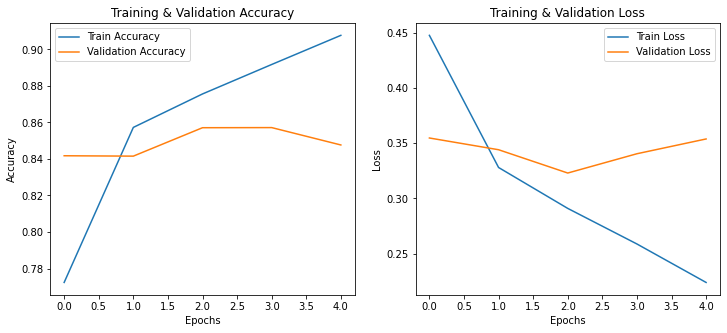

In [19]:
# 학습 과정 시각화 (정확도 & 손실 그래프 추가)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

In [20]:
# df_test를 최종 평가 데이터로 사용
X_final_test = sp_tokenize(sp, df_test['document'].tolist(), max_length)
y_final_test = np.array(df_test['label'].tolist())

In [21]:
# 최종 평가 수행
final_score, final_acc = model.evaluate(X_final_test, y_final_test)
y_final_pred = (model.predict(X_final_test) > 0.5).astype("int32")

1518/1518 [==============================] - 6s 4ms/step - loss: 0.3594 - accuracy: 0.8454


In [22]:
print(f"Final Test Accuracy: {final_acc:.4f}")
print("Final Classification Report:")
print(classification_report(y_final_test, y_final_pred))

Final Test Accuracy: 0.8454
Final Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.85     24181
           1       0.90      0.78      0.84     24371

    accuracy                           0.85     48552
   macro avg       0.85      0.85      0.84     48552
weighted avg       0.85      0.85      0.84     48552



### 최종 확인

In [23]:
# 1. 샘플 문장 토큰화 결과 확인
sample_texts = df_test['document'].sample(3).tolist()
for text in sample_texts:
    print(f"Original: {text}")
    print(f"Tokenized: {sp.encode_as_pieces(text)}")
    print(f"Token IDs: {sp.encode_as_ids(text)}")
    print("-" * 50)

Original: 다큐멘터리를본기분 이게과연픽션일까하는의문만들었습니다
Tokenized: ['▁다큐멘', '터', '리를', '본', '기', '분', '▁이게', '과', '연', '픽', '션', '일까', '하는', '의', '문', '만들', '었습니다']
Token IDs: [2495, 3557, 1174, 3523, 3437, 3536, 232, 3513, 3476, 4050, 3624, 1693, 52, 3440, 3615, 569, 799]
--------------------------------------------------
Original: 시작부터 끝까지 제대로 잘빠진 영화 갠적으로 락 스탁 투 스모킹 배럴즈 보다도 이 영화가 더 잘나왔다고 생각됨 가이 리치 감독이 이 감각으로는 못돌아가겠지
Tokenized: ['▁시작', '부터', '▁끝까지', '▁제대로', '▁잘', '빠', '진', '▁영화', '▁', '갠', '적으로', '▁', '락', '▁스', '탁', '▁투', '▁스', '모', '킹', '▁배', '럴', '즈', '▁보다', '도', '▁이', '▁영화가', '▁더', '▁잘', '나왔', '다고', '▁생각', '됨', '▁가', '이', '▁리', '치', '▁감독이', '▁이', '▁감', '각', '으로', '는', '▁못', '돌아', '가', '겠지']
Token IDs: [711, 247, 465, 651, 58, 3694, 3471, 4, 3423, 4346, 240, 3423, 3907, 39, 4152, 1094, 39, 3517, 4195, 74, 4059, 3700, 650, 3433, 5, 176, 62, 58, 2987, 201, 78, 3944, 41, 3424, 385, 3539, 712, 5, 24, 3540, 29, 3426, 83, 2659, 3431, 1198]
--------------------------------------------------
Original: 보다가 

In [24]:
# 2. 데이터 패딩 확인
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_final_test shape: {X_final_test.shape}")

X_train shape: (129509, 65), X_val shape: (14390, 65), X_final_test shape: (48552, 65)


In [26]:
# 3. 모델 예측 확인
sample_indices = np.random.choice(len(X_final_test), 10, replace=False)
for idx in sample_indices:
    pred = model.predict(X_final_test[idx].reshape(1, -1))
    label = y_final_test[idx]
    print(f"Sentence: {df_test.iloc[idx]['document']}")
    print(f"Predicted: {pred[0][0]:.4f} -> {'Positive' if pred[0][0] > 0.5 else 'Negative'} (Actual: {'Positive' if label == 1 else 'Negative'})")
    print("-" * 50)

Sentence: 시선이나 내용이 참 기억에 오래 남는 영화 마지막 장면의 Reverse gear가 참 기분 좋았음
Predicted: 0.9971 -> Positive (Actual: Positive)
--------------------------------------------------
Sentence: 잔잔하고 가슴 따뜻한 영화 한국 영화의 재발견
Predicted: 0.9830 -> Positive (Actual: Positive)
--------------------------------------------------
Sentence: 5번째 보는데도 역시 최고앞으로도 평생 두고두고 볼만한 드라마
Predicted: 0.9993 -> Positive (Actual: Positive)
--------------------------------------------------
Sentence: 알바 아님 잼있어요
Predicted: 0.9304 -> Positive (Actual: Positive)
--------------------------------------------------
Sentence: 정말 재밌네요 오랜만에 쟈밌는영화 봤습니다 강츄
Predicted: 0.9881 -> Positive (Actual: Positive)
--------------------------------------------------
Sentence: 감동의 물결이었습니다 눈물나네요 와리스 디리 화이팅
Predicted: 0.9688 -> Positive (Actual: Positive)
--------------------------------------------------
Sentence: 짝퉁 찌끄레기
Predicted: 0.0173 -> Negative (Actual: Negative)
--------------------------------------------------
Sentence: 박보영 이뽀다 그거 말곤 볼게 없다
Predicted